<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/labmeeting/Oct18/DeepSHAP_Unimodal_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup: Pull in the relevant data and load it

In [1]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5

#install deeplift for the dinucleotide shuffle functionality
# and the visualization functionality
!pip install deeplift
  
import numpy as np
import gzip

onehot_mapping = {
    'A': [1,0,0,0],
    'C': [0,1,0,0],
    'G': [0,0,1,0],
    'T': [0,0,0,1],
    'a': [1,0,0,0],
    'c': [0,1,0,0],
    'g': [0,0,1,0],
    't': [0,0,0,1],
}
def one_hot_encode(sequence):
  return np.array([onehot_mapping[x] for x in sequence])
  
onehot_sequences = np.array(
    [one_hot_encode(x.decode("utf-8").split("\t")[1])
     for (i,x) in enumerate(gzip.open("sequences.simdata.gz"))
     if i > 0])

from keras.models import model_from_json
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

--2019-10-18 17:18:36--  https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 629502 (615K) [application/octet-stream]
Saving to: ‘sequences.simdata.gz’

sequences.simdata.g 100%[===================>] 614.75K  --.-KB/s    in 0.05s   

2019-10-18 17:18:37 (11.6 MB/s) - ‘sequences.simdata.gz’ saved [629502/629502]

--2019-10-18 17:18:37--  https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Install SHAP - using my local branch because it has features that I have not yet made a PR for

In [2]:
!git clone https://github.com/AvantiShri/shap.git
%cd /content/shap
!pip uninstall shap
!git pull
!pip install .
%cd /content

Cloning into 'shap'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 4813 (delta 4), reused 3 (delta 0), pack-reused 4800
Receiving objects: 100% (4813/4813), 112.03 MiB | 28.98 MiB/s, done.
Resolving deltas: 100% (3127/3127), done.
Checking out files: 100% (260/260), done.
/content/shap
Already up to date.
Processing /content/shap
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=347372 sha256=38db1d088e321f6c9c84d0e24474c13e220ce3da7d90d3b43cd44ae6cfa8ea0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0kwogxqu/wheels/08/fe/b1/461bb216b26aa22db99708d72d320d2f3637775309af9f79b5
Successfully built shap
/content


For our SHAP function, we will need to define a function that returns the references to use for each input. The function will take a single input and then return a collection of references. In this case, we will generate references by dinucleotide shuffling the input sequences

In [0]:
from deeplift.dinuc_shuffle import dinuc_shuffle
import numpy as np

def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
  assert len(list_containing_input_modes_for_an_example)==1
  onehot_seq = list_containing_input_modes_for_an_example[0]
  rng = np.random.RandomState(seed)
  to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(10)])
  return [to_return] #wrap in list for compatibility with multiple modes

Instantiate the shap explainer

In [45]:
import shap
explainer = shap.DeepExplainer(
    model=([keras_model.input], keras_model.layers[-2].output[:,0]),
    data=dinuc_shuffle_several_times)

In [49]:
shap_values = explainer.shap_values(onehot_sequences[:1000],
                                    progress_message=100)

Done 0 examples of 1000
Done 100 examples of 1000
Done 200 examples of 1000
Done 300 examples of 1000
Done 400 examples of 1000
Done 500 examples of 1000
Done 600 examples of 1000
Done 700 examples of 1000
Done 800 examples of 1000
Done 900 examples of 1000


In [50]:
shap_values.shape

(1000, 200, 4)

If we don't project onto the bases that are actuall present, this is what happens...

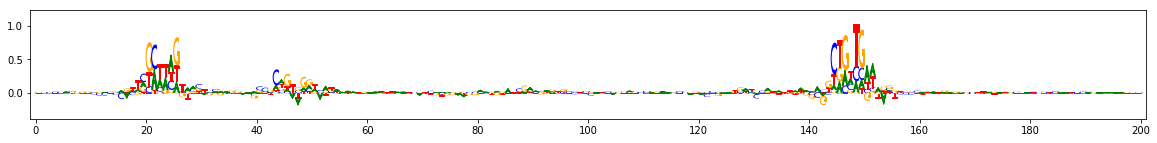

In [55]:
from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(shap_values[2], subticks_frequency=20)

With the projection...

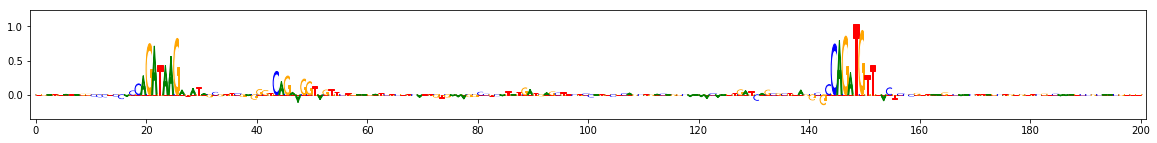

In [56]:
viz_sequence.plot_weights(onehot_sequences[2]*np.sum(shap_values[2], axis=-1)[:,None], subticks_frequency=20)

Let's get SHAP to do that projection for us automatically...

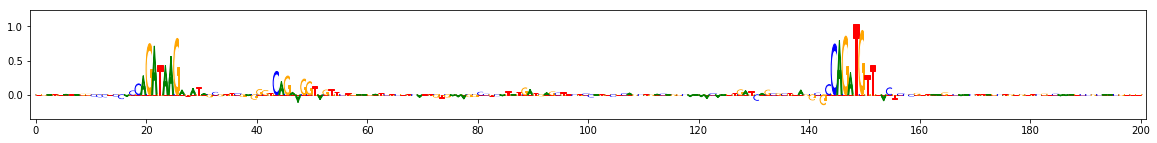

In [62]:
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    assert len(mult)==1
    difference_from_reference = orig_inp[0][None,:,:] - bg_data[0]
    contribs = difference_from_reference*mult[0]
    summed_along_position_contribs = np.sum(contribs, axis=-1)
    mean_contrib_over_references = np.mean(summed_along_position_contribs,
                                           axis=0)
    projected = orig_inp[0]*mean_contrib_over_references[:,None]
    return [projected]
  
explainer = shap.DeepExplainer(model=([keras_model.input],
    keras_model.layers[-2].output[:,0]), data=dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_values = explainer.shap_values(onehot_sequences[:10])
viz_sequence.plot_weights(shap_values[2], subticks_frequency=20)

Let's extend the combine_mult_and_diffref to also give us hypothetical scores...

hypothetical contributions:


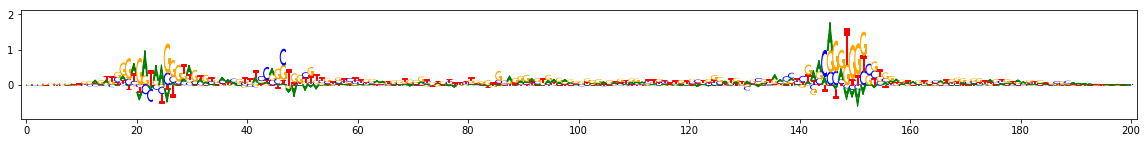

Actual contributions:


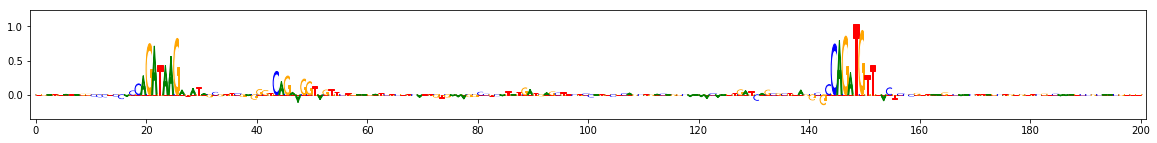

In [67]:

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    assert len(orig_inp)==1
    projected_hypothetical_contribs = np.zeros_like(bg_data[0]).astype("float")
    assert len(orig_inp[0].shape)==2
    #At each position in the input sequence, we iterate over the one-hot encoding
    # possibilities (eg: for genomic sequence, this is ACGT i.e.
    # 1000, 0100, 0010 and 0001) and compute the hypothetical 
    # difference-from-reference in each case. We then multiply the hypothetical
    # differences-from-reference with the multipliers to get the hypothetical contributions.
    #For each of the one-hot encoding possibilities,
    # the hypothetical contributions are then summed across the ACGT axis to estimate
    # the total hypothetical contribution of each position. This per-position hypothetical
    # contribution is then assigned ("projected") onto whichever base was present in the
    # hypothetical sequence.
    #The reason this is a fast estimate of what the importance scores *would* look
    # like if different bases were present in the underlying sequence is that
    # the multipliers are computed once using the original sequence, and are not
    # computed again for each hypothetical sequence.
    for i in range(orig_inp[0].shape[-1]):
        hypothetical_input = np.zeros_like(orig_inp[0]).astype("float")
        hypothetical_input[:,i] = 1.0
        hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[0])
        hypothetical_contribs = hypothetical_difference_from_reference*mult[0]
        projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
    return [np.mean(projected_hypothetical_contribs,axis=0)]


explainer = shap.DeepExplainer(model=([keras_model.input],
    keras_model.layers[-2].output[:,0]), data=dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_values = explainer.shap_values(onehot_sequences[:10])
print("hypothetical contributions:")
viz_sequence.plot_weights(shap_values[2], subticks_frequency=20)
print("Actual contributions:")
viz_sequence.plot_weights(shap_values[2]*onehot_sequences[2],
                          subticks_frequency=20)